**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on December 30th, 2023.

In [1]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

## Set up the StatsBombLoader

In [3]:
# Use this if you want to use the free public statsbomb data
# or provide credentials to access the API
# SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
datafolder = "/home/r-maejima/work/open-data/data" # Example of local folder with statsbomb data
SBL = StatsBombLoader(root=datafolder, getter="local")

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'African Cup of Nations',
 'Champions League',
 'Copa America',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [5]:
# Fifa world cup
selected_competitions = competitions[
    (competitions.competition_name == "Premier League")
    & (competitions.season_name == "2015/2016")
]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
64,27,2,Premier League,England,male,2015/2016


In [6]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
game_ids = [3754098, 3754281, 3753991]
game_num = 0
games = games[games["game_id"] == game_ids[game_num]]
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
69,33,24,2015-10-31 13:45:00,1,3


## Load and convert match data

In [7]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events, 
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data:   0%|          | 0/1 [00:00<?, ?it/s]/home/r-maejima/anaconda3/envs/tracklab/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
/home/r-maejima/anaconda3/envs/tracklab/lib/python3.10/site-packages/socceraction/data/statsbomb/loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["counterpress"] = eventsdf["counterpress"].fillna(False).astype(bool)
/home/r-maejima/anaconda3/

## Store converted spadl data in a h5-file

In [8]:
# pip install tables

datafolder = "/home/r-maejima/work/data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [9]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "Premier League")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3754098,15d6f3c0-55b2-468a-a9e4-19900598d3f7,1,0.482,24,4090.0,52.9375,33.575,52.8500,29.580,0,1,5,0,pass,success,foot_right,Adam Lallana,Liverpool
1,3754098,fc444d84-0a2a-4605-aaeb-1355aa86968d,1,0.811,24,3535.0,52.8500,29.580,49.5250,26.860,21,1,0,1,dribble,success,foot,Roberto Firmino,Liverpool
2,3754098,ffb0664c-d4f4-4760-9cd1-611324fef232,1,2.377,24,3535.0,49.5250,26.860,58.7125,4.335,0,1,5,2,pass,success,foot_right,Roberto Firmino,Liverpool
3,3754098,4235c2f6-1f30-4b82-a230-5f90d1b052b0,1,4.486,24,3515.0,58.7125,4.335,57.6625,3.910,21,1,0,3,dribble,success,foot,Alberto Moreno,Liverpool
4,3754098,aea1af9c-e967-4b13-87c9-b944cf87b10c,1,5.676,24,3515.0,57.6625,3.910,43.4875,6.885,0,1,4,4,pass,success,foot_left,Alberto Moreno,Liverpool


## 座標データ追加

In [10]:
import importlib
from ipywidgets import interact, IntSlider, fixed
import edit.file_manager as fm
import edit.search as sea
import edit.create as cre
import edit.edit_func as ef
import edit.plot as plot
importlib.reload(fm)
importlib.reload(sea)
importlib.reload(cre)
importlib.reload(ef)
importlib.reload(plot)

# ファイルパスの設定
data_path_list = []
data_path_list.append("/home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool")
data_path_list.append("/home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2016-02-07 - 19-00 Chelsea 1 - 1 Manchester United")
data_path_list.append("/home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2016-03-02 - 23-00 Liverpool 3 - 0 Manchester City")

data_path = data_path_list[game_num]
print(data_path)

/home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool


In [27]:
# テキストファイル作成
# ディレクトリが存在しない場合は作成
os.makedirs(data_path, exist_ok=True)

# 作成するファイル名のリスト
filenames = ["AnyInfos.txt", "CornerInfos.txt", "PlayerInfos.txt", "Substitutions.txt"]

# 各ファイルに "fin" を書き込む
for filename in filenames:
    file_path = os.path.join(data_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, "w", encoding="utf-8") as f:
            f.write("fin")
        print(f"{filename} を作成しました")
    else:
        print(f"{filename} は既に存在します")

AnyInfos.txt は既に存在します
CornerInfos.txt を作成しました
PlayerInfos.txt を作成しました
Substitutions.txt を作成しました


In [11]:
# 選手名の一部からあてはまる選手を検索
keyword = "cou"
sea.search_players(actions, keyword)

Philippe Coutinho


In [12]:
# 後半の検索
sea.search_second_half(actions)

1162


In [11]:
# ファイルマネージャー作成
manager = fm.FileManager(data_path)

# データの読み込み
simple_data_1, simple_data_2 = manager.load_files()

# その他ファイル読み込み
team_names, delete_ranges = manager.load_any_file()
print(team_names)

Loaded /home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool/1/simple_data.json
Loaded /home/r-maejima/work/soccernet/data/outputData/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool/2/simple_data.json
{'left': 'Liverpool', 'right': 'Chelsea'}


In [12]:
# 背番号と名前の対応関係作成
player_names, player_infos = manager.load_player_file()
print(player_names)
print(player_infos)

{'Liverpool': {'2': 'Nathaniel Clyne', '37': 'Martin Škrtel', '17': 'Mamadou Sakho', '18': 'Alberto Moreno', '7': 'James Milner', '21': 'Lucas Leiva', '23': 'Emre Can', '20': 'Adam Lallana', '10': 'Philippe Coutinho', '11': 'Roberto Firmino', '9': 'Christian Benteke', '33': 'Jordon Ibe', '6': 'Dejan Lovren', '22': 'Simon Mignolet'}, 'Chelsea': {'5': 'Kurt Zouma', '24': 'Gary Cahill', '26': 'John Terry', '28': 'César Azpilicueta', '7': 'Ramires', '12': 'John Obi Mikel', '22': 'Willian', '10': 'Eden Hazard', '8': 'Oscar', '19': 'Diego Costa', '16': 'Kenedy', '4': 'Cesc Fàbregas', '9': 'Falcao', '1': 'Asmir Begović'}}
{'Nathaniel Clyne': {'team_name': 'Liverpool', 'jersey': '2', 'position': 'DF', 'rating': 6.8}, 'Martin Škrtel': {'team_name': 'Liverpool', 'jersey': '37', 'position': 'DF', 'rating': 6.9}, 'Mamadou Sakho': {'team_name': 'Liverpool', 'jersey': '17', 'position': 'DF', 'rating': 6.9}, 'Alberto Moreno': {'team_name': 'Liverpool', 'jersey': '18', 'position': 'DF', 'rating': 7.0}

In [13]:
# 座標データ作成
location_data_list = cre.create_location_data(actions, simple_data_1, simple_data_2, team_names, player_names)
print(location_data_list[0])
print(len(location_data_list))

{'Martin Škrtel': {'location': [70.86111571110663, 24.70347805626681], 'jersey': '37', 'team': 'Liverpool'}, 'Mamadou Sakho': {'location': [71.99611203871497, 16.868504390822274], 'jersey': '17', 'team': 'Liverpool'}, 'Nathaniel Clyne': {'location': [67.78559312283348, 42.35528993793359], 'jersey': '2', 'team': 'Liverpool'}, 'James Milner': {'location': [48.69036391582029, 45.39494431400656], 'jersey': '7', 'team': 'Liverpool'}, 'Lucas Leiva': {'location': [62.92081127833774, 26.39137215439004], 'jersey': '21', 'team': 'Liverpool'}, 'Emre Can': {'location': [62.52038423198818, 18.403377326117592], 'jersey': '23', 'team': 'Liverpool'}, 'Alberto Moreno': {'location': [62.74593928666173, 9.640790990715573], 'jersey': '18', 'team': 'Liverpool'}, 'Adam Lallana': {'location': [52.30333954543333, 22.474000959206503], 'jersey': '20', 'team': 'Liverpool'}, 'Philippe Coutinho': {'location': [51.811973950778196, 12.340289523910169], 'jersey': '10', 'team': 'Liverpool'}, 'Roberto Firmino': {'locat

In [14]:
# 座標補正
print(delete_ranges)
ef.edit_data_auto(actions, location_data_list, delete_ranges)
print(location_data_list[0])

[(2162, 2192)]
{'Martin Škrtel': {'location': [71.4952761656733, 35.804477097060314], 'jersey': '37', 'team': 'Liverpool'}, 'Mamadou Sakho': {'location': [72.63027249328164, 27.969503431615774], 'jersey': '17', 'team': 'Liverpool'}, 'Nathaniel Clyne': {'location': [68.41975357740014, 53.45628897872709], 'jersey': '2', 'team': 'Liverpool'}, 'James Milner': {'location': [49.32452437038696, 56.49594335480006], 'jersey': '7', 'team': 'Liverpool'}, 'Lucas Leiva': {'location': [63.554971732904406, 37.49237119518354], 'jersey': '21', 'team': 'Liverpool'}, 'Emre Can': {'location': [63.15454468655485, 29.504376366911092], 'jersey': '23', 'team': 'Liverpool'}, 'Alberto Moreno': {'location': [63.3800997412284, 20.741790031509073], 'jersey': '18', 'team': 'Liverpool'}, 'Adam Lallana': {'location': [52.9375, 33.575], 'jersey': '20', 'team': 'Liverpool'}, 'Philippe Coutinho': {'location': [52.446134405344864, 23.44128856470367], 'jersey': '10', 'team': 'Liverpool'}, 'Roberto Firmino': {'location': [

In [15]:
# コーナー情報の追加
corner_infos = manager.load_corner_file()
print(corner_infos)
ef.add_corner_infos(location_data_list, player_infos, corner_infos)

{(1311, 1318): ('Adam Lallana', [0.4375, 67.575]), (1427, 1440): ('James Milner', [43.8375, 65.195]), (1427, 1435): ('Adam Lallana', [42.875, 48.79]), (1436, 1440): ('Adam Lallana', [44.0125, 53.72])}


In [16]:
# 交代情報の取得
substitutions = manager.load_substitution_file()
print(substitutions)

# フィールド選手情報の作成
field_players = cre.create_field_players(location_data_list, player_infos, substitutions)
print(field_players)

[('Kenedy', 'Eden Hazard'), ('Christian Benteke', 'James Milner'), ('Cesc Fàbregas', 'John Obi Mikel'), ('Jordon Ibe', 'Roberto Firmino'), ('Falcao', 'César Azpilicueta'), ('Dejan Lovren', 'Adam Lallana')]
{0: ['Nathaniel Clyne', 'Martin Škrtel', 'Mamadou Sakho', 'Alberto Moreno', 'James Milner', 'Lucas Leiva', 'Emre Can', 'Adam Lallana', 'Philippe Coutinho', 'Roberto Firmino', 'Kurt Zouma', 'Gary Cahill', 'John Terry', 'César Azpilicueta', 'Ramires', 'John Obi Mikel', 'Willian', 'Eden Hazard', 'Oscar', 'Diego Costa'], 1441: ['Nathaniel Clyne', 'Martin Škrtel', 'Mamadou Sakho', 'Alberto Moreno', 'James Milner', 'Lucas Leiva', 'Emre Can', 'Adam Lallana', 'Philippe Coutinho', 'Roberto Firmino', 'Kurt Zouma', 'Gary Cahill', 'John Terry', 'César Azpilicueta', 'Ramires', 'John Obi Mikel', 'Willian', 'Oscar', 'Diego Costa', 'Kenedy'], 1533: ['Nathaniel Clyne', 'Martin Škrtel', 'Mamadou Sakho', 'Alberto Moreno', 'Lucas Leiva', 'Emre Can', 'Adam Lallana', 'Philippe Coutinho', 'Roberto Firmino'

In [17]:
# 欠損情報の補間
ef.interpolate_data(location_data_list, field_players)

# 人数の確認
for action_num, location_data in enumerate(location_data_list):
    if len(location_data) != 20:
        print(action_num)

In [18]:
# 描画
end_action_num = len(actions)
interact(
    plot.plot_action_data,
    actions=fixed(actions),
    game=fixed(game),
    location_data_list=fixed(location_data_list),
    action_num=IntSlider(min=0, max=end_action_num, step=1, value=0, description="Action")
)

interactive(children=(IntSlider(value=0, description='Action', max=2193), Output()), _dom_classes=('widget-int…

<function edit.plot.plot_action_data(actions: pandas.core.frame.DataFrame, game: pandas.core.frame.DataFrame, location_data_list: List[Dict[str, edit.type_def.SimpleInfo]], action_num: int) -> None>

In [19]:
# アクション数の削減
print(delete_ranges)
ef.reduct_actions(location_data_list, delete_ranges)

[(2162, 2192)]


In [20]:
# 座標データフレーム作成
action_locations = cre.create_action_locations(actions, location_data_list)
action_locations[game_ids[game_num]]

,game_id,period_id,team_id,player_id,location_x,location_y,action_id
0,3754098,1,24,18872.0,71.495276,35.804477,0
1,3754098,1,24,3483.0,72.630272,27.969503,0
2,3754098,1,24,4590.0,68.419754,53.456289,0
3,3754098,1,24,3473.0,49.324524,56.495943,0
4,3754098,1,24,7780.0,63.554972,37.492371,0
...,...,...,...,...,...,...,...
43855,3754098,2,33,3666.0,NaN,NaN,2192
43856,3754098,2,33,3445.0,NaN,NaN,2192
43857,3754098,2,24,3493.0,NaN,NaN,2192
43858,3754098,2,24,3635.0,NaN,NaN,2192


In [21]:
# 後からaction_locationsを追加保存
with pd.HDFStore(spadl_h5, mode='a') as spadlstore:
    for game_id in action_locations.keys():
        spadlstore[f"action_locations/game_{game_id}"] = action_locations[game_id]

with pd.HDFStore(spadl_h5) as store:
    print(store.keys())

['/competitions', '/games', '/player_games', '/players', '/teams', '/actions/game_3753991', '/actions/game_3754098', '/actions/game_3754281', '/action_locations/game_3753991', '/action_locations/game_3754098', '/action_locations/game_3754281']


873.495
2016-03-02 21:00:00 Liverpool 3-0 Manchester City 15'


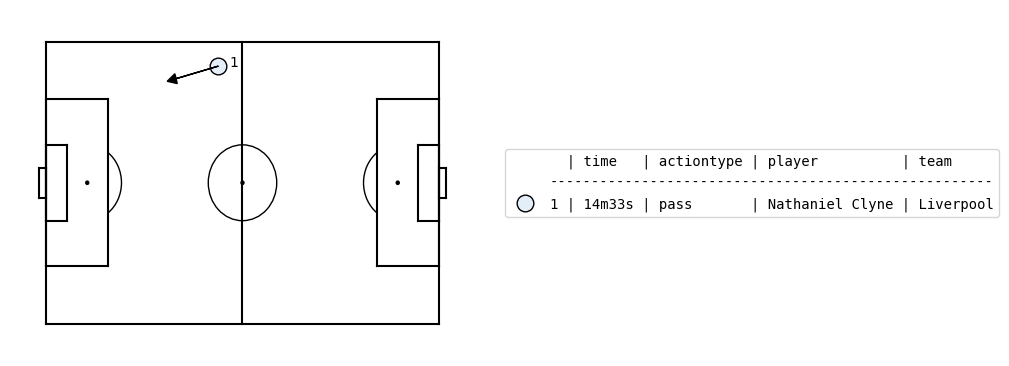

In [23]:
# pip install matplotsoccer

import matplotsoccer

# Select the 5 actions
shot = 357
a = actions[shot:shot+1].copy()

# Print the game date and timestamp
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(a.time_seconds.values[0])
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)